In [1]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=6b1d244fbc0a13358cbf5add4f9ce07d6f84f96fb8a01e36f46674a6815367f2
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [1]:
import pandas as pd
import glob
import csv
import numpy as np
from collections import Counter
from PIL import Image
import os
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.metrics import classification_report, confusion_matrix, precision_score,recall_score,f1_score
import time
import cv2
import copy
from tqdm.auto import tqdm
import h5py
import torch.nn.functional as F
from lime import lime_image
from skimage.segmentation import mark_boundaries
import glob

In [30]:
dml = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dml

device(type='cuda', index=0)

# For AMD GPU

In [2]:
import torch_directml
dml = torch_directml.device()
dml

device(type='privateuseone', index=0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

class_name = [classes[x] for x in classes]

In [4]:
torch.manual_seed(123)

In [5]:
def create_model():
    model = torchvision.models.inception_v3(pretrained=True)

    # for param in model.parameters():
    #     param.requires_grad = False
    
    num_ftrs = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_ftrs,  43)
    # Handle the primary net
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 43)

    return model.to(dml)

In [6]:
base_model = create_model()

C:\Users\aniat\miniconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aniat\miniconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model_path = 'Trained models/inceptionv3.pt'

In [8]:
best_model = base_model

In [9]:
if torch.cuda.is_available():
    best_model.load_state_dict(torch.load(model_path))
else:
    best_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

In [10]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize(size = 299),
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        # normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [11]:
def batch_predict(images):
    best_model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    best_model.to(dml)
    batch = batch.to(dml)
    
    logits = best_model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [12]:
def explain_image(image):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(np.array(pill_transf(image)), 
                                            batch_predict, # classification function
                                            top_labels=5, 
                                            hide_color=0, 
                                            num_samples=1000)
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    img_boundry1 = mark_boundaries(temp/255.0, mask)
  
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
  
    return np.array([img_boundry1, img_boundry2])

In [14]:
def get_image(path):
    with Image.open(path) as img:
        return img.convert('RGB') 


original_images = []
explained_images = []
image_paths = glob.glob("F:\CSE 4.2\CSE 4138 (Soft Computing Lab)\Images\img_1 - Copy.png")

for path in image_paths:
    img = get_image(path)
    original_images.append(img)
    explained_images.append(explain_image(img))


  0%|          | 0/1000 [00:00<?, ?it/s]

# Model prediction of images

In [15]:
pill_images = [pill_transf(img) for img in original_images]
pred_classes = [classes[cls_id] for cls_id in list(np.argmax(batch_predict(pill_images), axis=1))]

# Plot all images

**First row contains original images**

**Second and third row contains interpreted images**

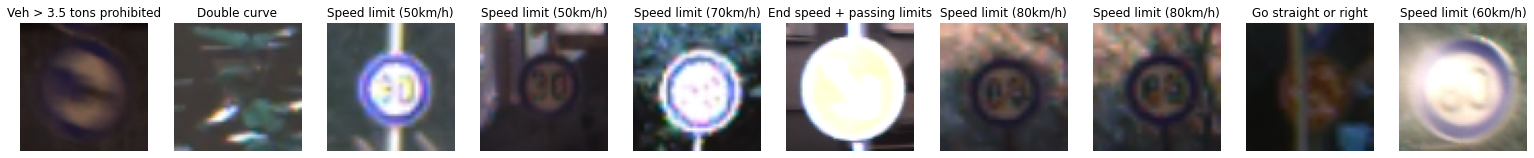

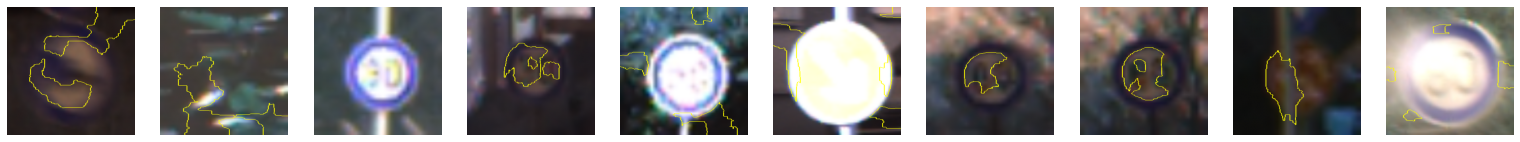

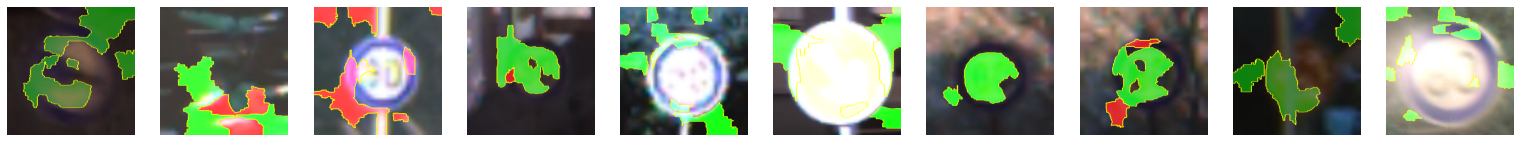

In [17]:
_, axs = plt.subplots(1, 10, figsize=(27, 27))
axs = axs.flatten()
for class_name, img, ax in zip(pred_classes, original_images, axs):
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')

plt.show()

_, axs = plt.subplots(1, 10, figsize=(27, 27))
axs = axs.flatten()
for img, ax in zip(explained_images, axs):
    ax.imshow(img[0])
    ax.axis('off')

plt.show()

_, axs = plt.subplots(1, 10, figsize=(27, 27))
axs = axs.flatten()
for img, ax in zip(explained_images, axs):
    ax.imshow(img[1])
    ax.axis('off')
    
plt.show()

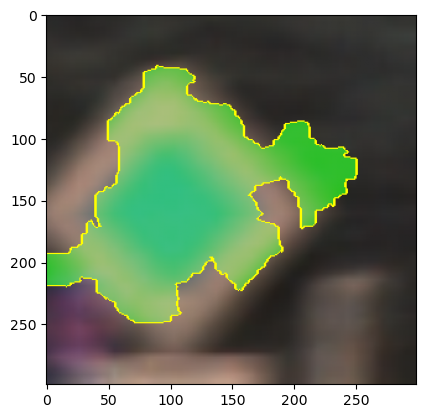

['Priority road']

In [16]:
plt.imshow(explained_images[0][1])
plt.show()
pred_classes

In [18]:
matplotlib.image.imsave(f"F:\CSE 4.2\CSE 4138 (Soft Computing Lab)\Images/InceptionV3.png", explained_images[0][1])

In [62]:
matplotlib.image.imsave(f"F:/Notebook/Softcom Lab/Images/InceptionV3_Good.png", explained_images[0][1])

In [63]:
torch. cuda. empty_cache()

In [18]:
for ind, img in enumerate(explained_images): 
    matplotlib.image.imsave(f"/content/drive/MyDrive/Uploaded/Softcom Lab/Images/Inception Misclassified/LIME/img_{ind + 1}.png", img[1])